In [1]:
# import necessary libraries
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tqdm import tqdm
from keras.preprocessing import image
from tkinter import filedialog
from tkinter import Tk

In [2]:
# Define directories
TRAINING_DIR = 'D:\\Project\\capstone\\dataset\\apaantuh\\train'
VAL_DIR = 'D:\\Project\\capstone\\dataset\\apaantuh\\test'

In [3]:
# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Defines the image size and create a generator for training data
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    class_mode='categorical',
    batch_size=64,
    target_size=(150, 150)
)

# Create data generators for validation data
test_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    class_mode='categorical',
    batch_size=32,
    target_size=(150, 150)
)

types_dict = train_generator.class_indices
print(types_dict)

Found 2400 images belonging to 8 classes.
Found 810 images belonging to 8 classes.
{'Biru': 0, 'Coklat': 1, 'Hijau': 2, 'Hitam': 3, 'Jingga': 4, 'Kuning': 5, 'Merah': 6, 'Putih': 7}


In [4]:
# Define a custom callback to monitor and stop training when the desired accuracy is reached
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print("\nAccuracy is more than 95%, stopping...")
            self.model.stop_training = True

In [5]:
# Define the neural network model for image classification
model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(8, activation='softmax')
])

In [6]:
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [7]:
# Compile the model with the optimizer, loss function, and metrics
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

In [8]:
# Call Callback functionn
customCallback = myCallback()

# Train the model using the data generators and stop when the custom callback are met
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[customCallback]
)

Epoch 1/100


38/38 [==============================] - 68s 2s/step - loss: 1.0896 - accuracy: 0.6212 - val_loss: 0.4185 - val_accuracy: 0.8383
Epoch 2/100
38/38 [==============================] - 68s 2s/step - loss: 0.3794 - accuracy: 0.8654 - val_loss: 0.4959 - val_accuracy: 0.8062
Epoch 3/100
38/38 [==============================] - 72s 2s/step - loss: 0.2424 - accuracy: 0.9262 - val_loss: 0.1315 - val_accuracy: 0.9556
Epoch 4/100
38/38 [==============================] - 72s 2s/step - loss: 0.1658 - accuracy: 0.9433 - val_loss: 0.0529 - val_accuracy: 0.9951
Epoch 5/100
38/38 [==============================] - 83s 2s/step - loss: 0.1843 - accuracy: 0.9413 - val_loss: 0.1154 - val_accuracy: 0.9753
Epoch 6/100
38/38 [==============================] - 74s 2s/step - loss: 0.1921 - accuracy: 0.9333 - val_loss: 0.0872 - val_accuracy: 0.9642
Epoch 7/100
38/38 [==============================] - 78s 2s/step - loss: 0.1297 - accuracy: 0.9613 - val_loss: 0.1216 - val_accuracy: 0.9469
Epoch 8/100

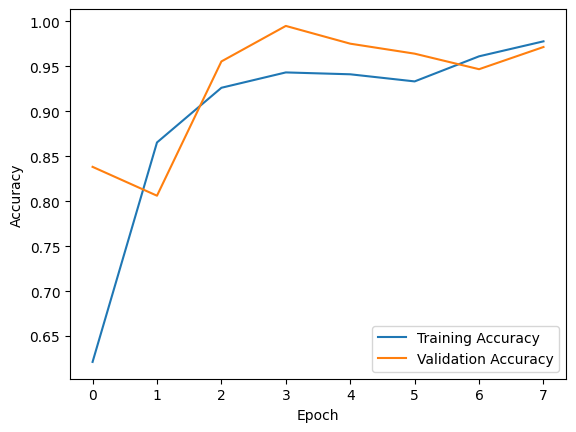

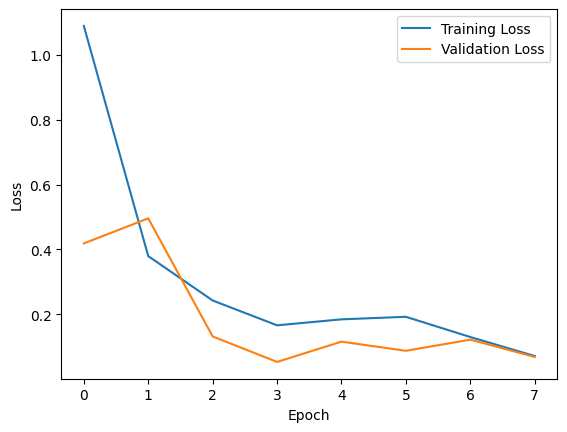

In [9]:
# Plotting Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('result/accuracy_plot.png')
plt.show()

# Plotting Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('result/loss_plot.png')
plt.show()

In [10]:
# Save the trained model in SavedModel format and convert it to TensorFlow Lite format
result_directory = "result"
tf.saved_model.save(model, result_directory)
model.save('result/best_model.h5')
loaded = tf.saved_model.load(result_directory)
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)
converter = tf.lite.TFLiteConverter.from_saved_model(result_directory)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
tflite_model_file = 'result/converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()

INFO:tensorflow:Assets written to: result\assets


INFO:tensorflow:Assets written to: result\assets
d:\Aplikasi\Program\Python\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['serving_default']
((), {'conv2d_input': TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='conv2d_input')})
{'dense_1': TensorSpec(shape=(None, 8), dtype=tf.float32, name='dense_1')}
